In [1]:
# Uncommon packages
# !pip install -q split-folders optuna optuna-integration plotly nbformat

### Importing key libraries

In [2]:
import os, json, yaml, warnings, random
import numpy as np, matplotlib.pyplot as plt, tensorflow as tf
from sklearn import metrics
import optuna

warnings.filterwarnings('ignore')

# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

### TF configuration

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
for gpu in physical_devices:
    tf.config.experimental.set_memory_growth(gpu, True)

### Non-optimized hyperparameters

In [4]:
IMG_SIZE = 224
NUM_EPOCHS = 100 # doesn't matter much because of EarlyStopping
# EarlyStopping
PATIENCE = 5 # no. of epochs with no improvement after which training will be stopped
# ReduceLROnPlateau
LR_PATIENCE = 5 # no. of epochs with no improvement after which learning rate will be reduced
LR_FACTOR = 0.1 # factor by which the learning rate will be reduced
MIN_LR = 1e-6 # lower bound on the learning rate
# Optuna
OPTUNA_TRIALS = 60

### Dataset splitting (one-time)

In [5]:
output_dir = r'splitted_data' # Intentionally declared in separate cell

In [6]:
# import splitfolders

# dataset_dir = r'dataset'

# # Make output dir if doesn't exist, else skip
# os.makedirs(output_dir, exist_ok=True)

# splitfolders.ratio(dataset_dir, output=output_dir, seed=1337, ratio=(0.75, 0.15, 0.1))
# print(f"Dataset successfully splitted into: {os.listdir(output_dir)}")

### Dataset config

In [7]:
def helper_ds(partition, shuffle_status=True):
    return tf.keras.utils.image_dataset_from_directory(
        directory=os.path.join(output_dir, partition),
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=32,
        label_mode='binary',
        shuffle=shuffle_status
    )

train_ds = helper_ds('train')
val_ds = helper_ds('val')
test_ds = helper_ds('test', False)


# Rescale layer
rescale_layer = tf.keras.layers.Rescaling(1./255)

# Data augmentation for 'train' set
data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomContrast(0.2),
        tf.keras.layers.RandomBrightness(0.15),
        ])

AUTOTUNE = tf.data.AUTOTUNE

# Augmentation and rescaling for 'train' set
train_rsc = train_ds.map(lambda x, y: (rescale_layer(data_augmentation(x), training=True), y), num_parallel_calls=AUTOTUNE)
train_rsc = train_rsc.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# Only rescaling for 'test' and 'val' set
val_rsc = val_ds.map(lambda x, y: (rescale_layer(x), y), num_parallel_calls=AUTOTUNE).prefetch(buffer_size=AUTOTUNE)
test_rsc = test_ds.map(lambda x, y: (rescale_layer(x), y), num_parallel_calls=AUTOTUNE).prefetch(buffer_size=AUTOTUNE)

Found 31344 files belonging to 2 classes.
Found 6268 files belonging to 2 classes.
Found 4181 files belonging to 2 classes.


In [8]:
class_names = train_ds.class_names
print(f"Class names: {class_names}")

# Saving the class names
with open('class_names.json', 'w') as f:
    json.dump(class_names, f)

# Sanity check
print(f"Class names successfully saved.") if os.path.exists('class_names.json') else print(f"Failed to save the file.")

Class names: ['Drowsy', 'Non Drowsy']
Class names successfully saved.


### Data visualization

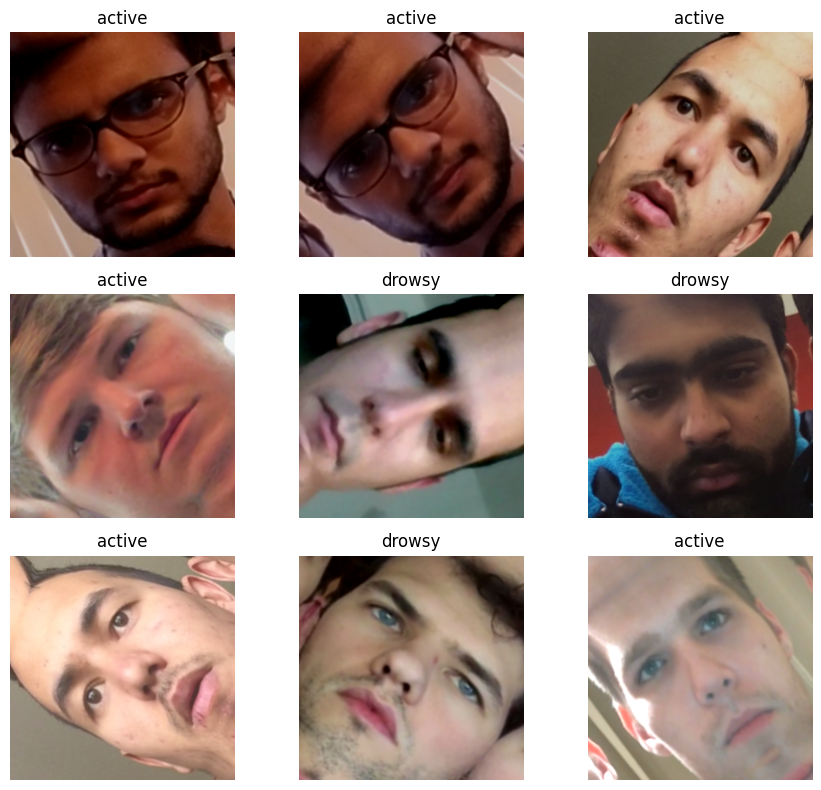

In [9]:
plt.figure(figsize=(10, 8))
for images, labels in train_rsc.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        state = "active" if int(labels[i]) else "drowsy"
        plt.title(state)
        plt.axis("off")
        plt.tight_layout()

### Stacking models

In [10]:
def stacked_model(input_shape=[IMG_SIZE, IMG_SIZE, 3], LEARNING_RATE=0.0001, HDN1=1024, HDN2=512, HDN3=256,
                  DROP1=0.2, DROP2=0.2, DROP3=0.2, ACTIVATION='relu'):

    d_net = tf.keras.applications.DenseNet121(include_top=False, weights='imagenet', input_shape=input_shape)
    e_net = tf.keras.applications.EfficientNetV2B2(include_top=False, weights='imagenet', input_shape=input_shape)
    m_net = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)

    # Freeze the models
    d_net.trainable=False; e_net.trainable=False; m_net.trainable=False

    # Input layer
    inputs = tf.keras.Input(shape=input_shape)

    # Averaging the outputs from each model
    d_net_gap = tf.keras.layers.GlobalAveragePooling2D()(d_net(inputs))
    e_net_gap = tf.keras.layers.GlobalAveragePooling2D()(e_net(inputs))
    m_net_gap = tf.keras.layers.GlobalAveragePooling2D()(m_net(inputs))

    # Combine outputs
    combined_outputs = tf.keras.layers.concatenate([d_net_gap, e_net_gap, m_net_gap])

    # Custom layers
    stacked_1 = tf.keras.layers.Dense(HDN1, activation=ACTIVATION)(combined_outputs)
    stacked_1 = tf.keras.layers.BatchNormalization()(stacked_1)
    stacked_1 = tf.keras.layers.Dropout(DROP1)(stacked_1)

    stacked_2 = tf.keras.layers.Dense(HDN2, activation=ACTIVATION)(stacked_1)
    stacked_2 = tf.keras.layers.BatchNormalization()(stacked_2)
    stacked_2 = tf.keras.layers.Dropout(DROP2)(stacked_2)

    stacked_3 = tf.keras.layers.Dense(HDN3, activation=ACTIVATION)(stacked_2)
    stacked_3 = tf.keras.layers.BatchNormalization()(stacked_3)
    stacked_3 = tf.keras.layers.Dropout(DROP3)(stacked_3)

    out = tf.keras.layers.Dense(1, activation='sigmoid')(stacked_3)

    model = tf.keras.Model(inputs=inputs, outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                 loss='binary_crossentropy',
                 metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])
    return model

### Defining callbacks

In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=LR_FACTOR, patience=LR_PATIENCE, min_lr=MIN_LR)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("checkpoints/best_model.keras", monitor='val_loss', save_best_only=True, verbose=1)

# Custom training curve callback
from IPython.display import clear_output

train_losses=[]; val_losses=[]; precision_scores=[]; recall_scores=[]

class TrainingCurveCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_losses.append(logs['loss'])
        val_losses.append(logs['val_loss'])
        precision_scores.append(logs['precision'])
        recall_scores.append(logs['recall'])

        clear_output(wait=True) # clear output before plotting

        fig, ax1 = plt.subplots(figsize=(10, 5)) # create figure; will contain loss/accuracy curves
        fig.suptitle('Training Curves')

        # loss curve (ax1 - left y axis)
        ax1.plot(train_losses, label='Train Loss')
        ax1.plot(val_losses, label='Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_xlim(left=0)
        ax1.set_ylabel('Loss function')

        # determine left y axis range from min/max loss values
        y_ax1_min = min(min(train_losses), min(val_losses)) # find lowest loss value across both curves
        y_ax1_min = max(0, y_ax1_min - 0.1) # add some padding to the bottom of the plot. lower bound can't be less than 0
        y_ax1_max = max(max(train_losses), max(val_losses)) + 0.1 # find highest loss value across both curves, add some padding to the top of the plot
        ax1.set_ylim(y_ax1_min, y_ax1_max) # set y axis limits

        # Best epoch (smallest loss)
        best_epoch = int(np.argmin(val_losses))
        best_loss = val_losses[best_epoch]

        # add veritcal line for best epoch
        ax1.vlines(best_epoch, ymin=0, ymax=y_ax1_max, linestyles='dashed', colors='black',
                   label=f'best epoch={best_epoch}\nval loss={best_loss:.3f}')
        ax1.legend(loc='upper left')

        # create right y axis for precision/recall curves
        ax2 = ax1.twinx()

        # Plot precision/recall (right y-axis)
        ax2.plot(precision_scores, label=f'Precision\n{precision_scores[best_epoch]:.3f} @ {best_epoch}', color='red')
        ax2.plot(recall_scores, label=f'Recall\n{recall_scores[best_epoch]:.3f} @ {best_epoch}', color='green')
        ax2.set_ylabel('Precision / Recall')
        ax2.set_ylim(0, 1.1) # add some padding
        ax2.legend(loc='upper right')
        plt.tight_layout()
        plt.show()

### Model summary (optional)

In [12]:
# ensemble_model = stacked_model()
# ensemble_model.summary()

### Running Optuna (skippable)

In [13]:
def objective(trial: optuna.Trial):
    # Define the hyperparameter search space
    LEARNING_RATE = trial.suggest_loguniform('LEARNING_RATE', 1e-5, 1e-2)
    HDN1 = trial.suggest_int('HDN1', 256, 1024, step=256)
    HDN2 = trial.suggest_int('HDN2', 128, HDN1, step=128) # HDN1 ≥ HDN2
    HDN3 = trial.suggest_int('HDN3', 64, HDN2, step=64) # HDN2 ≥ HDN3
    DROP1 = trial.suggest_float('DROP1', 0.1, 0.5, step=0.1)
    DROP2 = trial.suggest_float('DROP2', 0.1, 0.5, step=0.1)
    DROP3 = trial.suggest_float('DROP3', 0.1, 0.5, step=0.1)
    ACTIVATION = trial.suggest_categorical('ACTIVATION', ["relu", "elu", "selu"])

    ensemble_model = stacked_model(LEARNING_RATE=LEARNING_RATE, HDN1=HDN1, HDN2=HDN2, HDN3=HDN3,
                                   DROP1=DROP1, DROP2=DROP2, DROP3=DROP3, ACTIVATION=ACTIVATION)

    optuna_pruner = optuna.integration.TFKerasPruningCallback(trial, monitor='val_loss')
    history = ensemble_model.fit(train_rsc, validation_data=val_rsc, epochs=NUM_EPOCHS, callbacks=[early_stopping, reduce_lr, optuna_pruner])
    
    return min(history.history['val_loss'])
    
study = optuna.create_study(
    study_name="ensemble_optim",
    direction="minimize",  # Minimize validation loss
    storage="sqlite:///optim_trial_data.db",
    load_if_exists=True)
study.optimize(objective, n_trials=OPTUNA_TRIALS, show_progress_bar=True)

[I 2025-07-16 13:54:17,122] A new study created in RDB with name: ensemble_optim


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 1/100
980/980 [==============================] - 422s 412ms/step - loss: 0.1970 - accuracy: 0.9203 - precision: 0.9150 - recall: 0.9135 - val_loss: 0.0680 - val_accuracy: 0.9740 - val_precision: 0.9602 - val_recall: 0.9849 - lr: 0.0014
Epoch 2/100
980/980 [==============================] - 398s 406ms/step - loss: 0.0776 - accuracy: 0.9728 - precision: 0.9716 - recall: 0.9698 - val_loss: 0.0430 - val_accuracy: 0.9844 - val_precision: 0.9947 - val_recall: 0.9715 - lr: 0.0014
Epoch 3/100
980/980 [==============================] - 397s 405ms/step - loss: 0.0556 - accuracy: 0.9800 - precision: 0.9793 - recall: 0.9776 - val_loss: 0.0290 - val_accuracy: 0.9896 - val_precision: 0.9931 - val_recall: 0.9846 - lr: 0.0014
Epoch 4/100
980/980 [==============================] - 396s 405ms/step - loss: 0.0428 - accuracy: 0.9853 - precision: 0.9840 - recall: 0.9843 - val_loss: 0.0560 - val_accuracy: 0.9785 - val_precision: 0.9561 - val_recall: 0.9997 - lr: 0.0014
Epoch 5/100
980/980 [===========

In [14]:
# Print the best trial's value and hyperparameters
print(f'Best value: {study.best_value}\nBest hyperparameters found: {study.best_params}')

# Save the best hyperparameters to a file
with open('best_hyperparameters.yaml', 'w') as f:
    yaml.dump(study.best_params, f)

Best value: 0.0022052754648029804
Best hyperparameters found: {'LEARNING_RATE': 0.0002254407339490558, 'HDN1': 1024, 'HDN2': 512, 'HDN3': 448, 'DROP1': 0.2, 'DROP2': 0.2, 'DROP3': 0.30000000000000004, 'ACTIVATION': 'relu'}


> Plot the timeline of the study.

In [15]:
optuna.visualization.plot_timeline(study)

> Plot optimization history of all trials.

In [16]:
optuna.visualization.plot_optimization_history(study)

> Plot hyperparameter importances.

In [17]:
optuna.visualization.plot_param_importances(study)

> Plot the parameter relationship as slice plot.

In [18]:
optuna.visualization.plot_slice(study, params=['LEARNING_RATE', 'ACTIVATION'])

### Training the final model

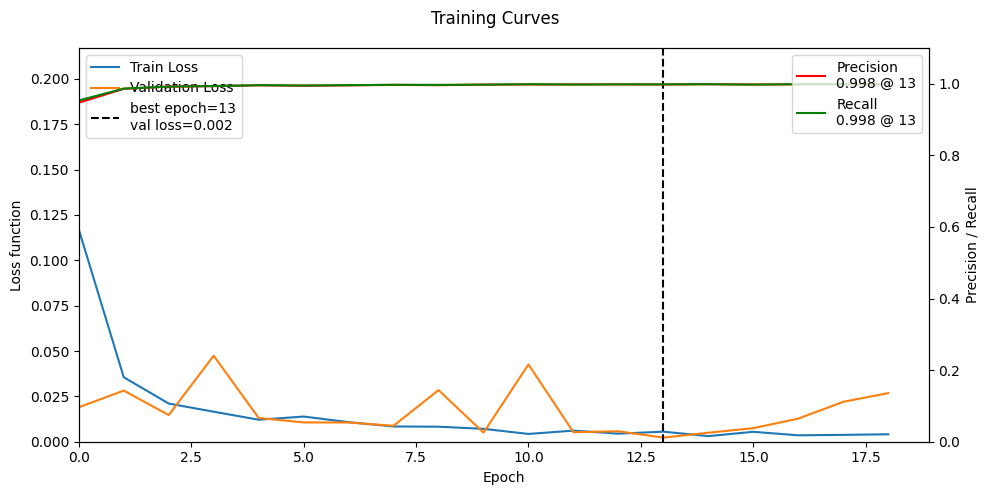

980/980 [==============================] - 402s 410ms/step - loss: 0.0041 - accuracy: 0.9985 - precision: 0.9986 - recall: 0.9981 - val_loss: 0.0268 - val_accuracy: 0.9930 - val_precision: 0.9855 - val_recall: 0.9997 - lr: 2.2544e-04


In [19]:
# Loading the stored hyperparameters in case I am not rerunning Optuna and want to train with previously saved values
with open('best_hyperparameters.yaml', 'r') as f:
    best_params = yaml.full_load(f)  

# Load the ensemble model again
ensemble_model = stacked_model(LEARNING_RATE=best_params['LEARNING_RATE'], HDN1=best_params['HDN1'], HDN2=best_params['HDN2'], 
                               HDN3=best_params['HDN3'], DROP1=best_params['DROP1'], DROP2=best_params['DROP2'],
                               DROP3=best_params['DROP3'], ACTIVATION=best_params['ACTIVATION'])

# If you want to skip Optuna, simply comment out the line above and uncomment the line below
# ensemble_model = stacked_model(LEARNING_RATE=0.0001, DROPOUT_RATE=0.2)

history = ensemble_model.fit(train_rsc, validation_data=val_rsc, epochs=NUM_EPOCHS, callbacks=[early_stopping, reduce_lr, TrainingCurveCallback()])

### Saving the model

In [20]:
model_filename = 'best_model.keras' # Intentionally declared in separate cell

In [21]:
ensemble_model.save(model_filename)

# Sanity check
print(f"Model successfully saved as {model_filename}") if os.path.exists(model_filename) else print(f"Failed to save the model.")

Model successfully saved as best_model.keras


### Loading the model

In [22]:
optimized_ensemble = tf.keras.models.load_model(model_filename) # Intentionally declared in separate cell

### Testing w/ `val` set

In [23]:
final_val_loss, final_val_accuracy, *rest = optimized_ensemble.evaluate(val_rsc)
print(f"Ensemble Model - Validation Loss: {final_val_loss:.4f}, Validation Accuracy: {final_val_accuracy:.4f}")

196/196 [==============================] - 71s 338ms/step - loss: 0.0022 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.9990
Ensemble Model - Validation Loss: 0.0022, Validation Accuracy: 0.9995


### Testing w/ `test` set

In [24]:
# Gather true test labels
y_true = []
for _, labels in test_rsc:
    y_true.extend(labels.numpy())

# Sanity check
assert len(y_true) > 1, "True label list is empty!"

# Predict on test dataset
y_pred = optimized_ensemble.predict(test_rsc)

131/131 [==============================] - 52s 365ms/step


<Figure size 800x800 with 0 Axes>

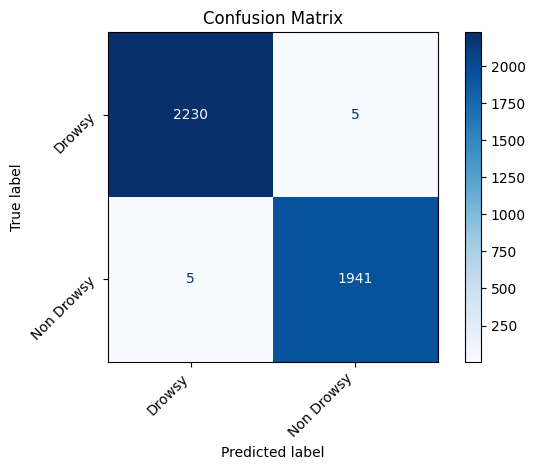

In [25]:
# Need to convert prediction labels to binary for confusion matrix
y_pred_conf = (y_pred >= 0.5).astype(int)

cm = metrics.confusion_matrix(y_true, y_pred_conf)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(8,8))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.xticks(rotation=45, ha='right') # Rotating labels for better readability
plt.yticks(rotation=45, ha='right')
plt.title('Confusion Matrix')
plt.tight_layout()
# plt.savefig("conf_matrix.png", dpi=300)
plt.show()

In [26]:
# Compute per-class accuracy
## REFERENCE: https://stackoverflow.com/questions/39770376/scikit-learn-get-accuracy-scores-for-each-class/65673016#comment116875554_50977153
pca = metrics.confusion_matrix(y_true, y_pred_conf, normalize="true").diagonal().tolist()
print(f"Per-class accuracy\n{class_names[0]}: {pca[0]*100:.3f}%, {class_names[1]}: {pca[1]*100:.3f}%")

Per-class accuracy
Drowsy: 99.776%, Non Drowsy: 99.743%


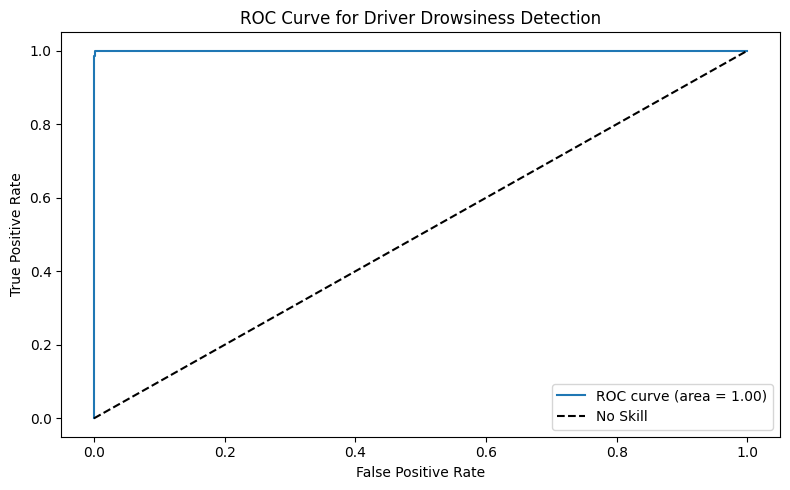

In [27]:
# Predict probabilities on the test set
fpr, tpr, _ = metrics.roc_curve(y_true, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Driver Drowsiness Detection')
plt.legend()
plt.tight_layout()
# plt.savefig("roc_curve.png", dpi=300)
plt.show()

1/1 [==============================] - 4s 4s/step


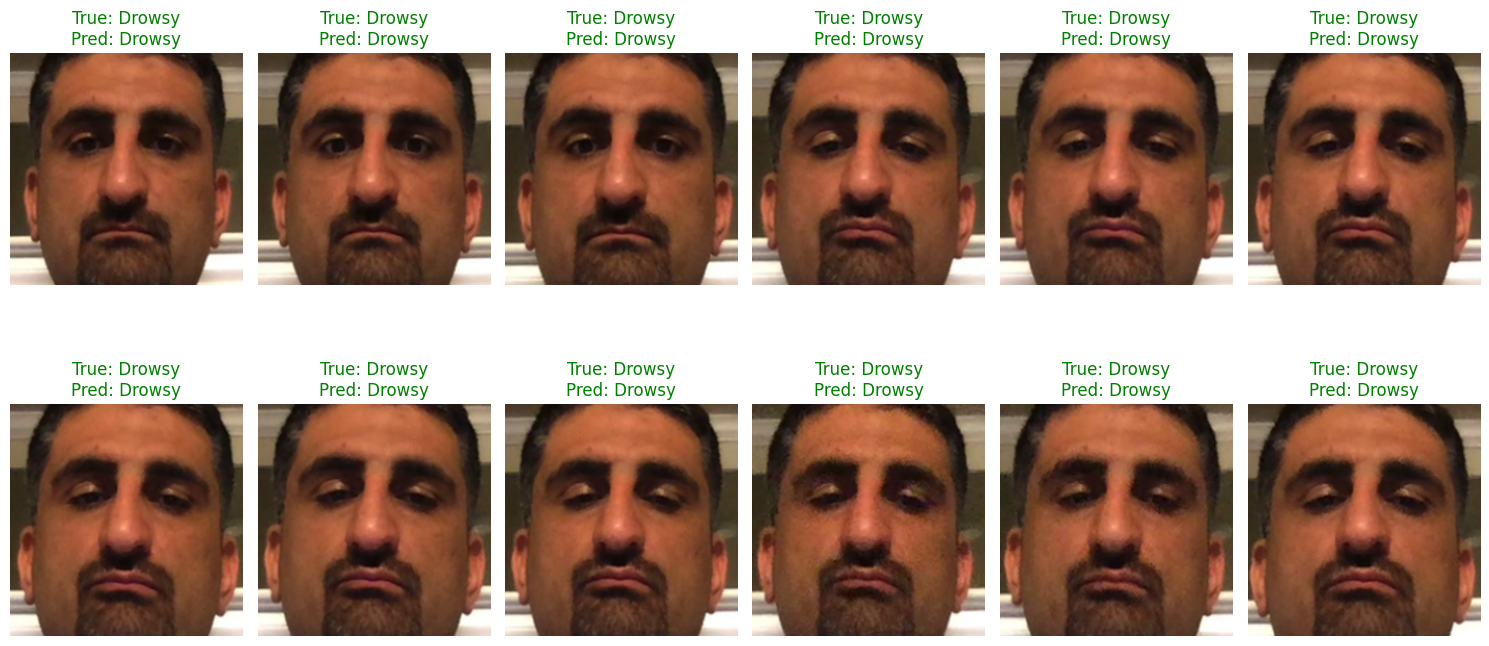

In [28]:
# Viz with test dataset
plt.figure(figsize=(15, 10))
for test_img, test_label in test_rsc.take(1):
    predicted_labels = optimized_ensemble.predict(test_img)
    
    for i in range(12):
        ax = plt.subplot(2, 6, i+1)
        plt.imshow(test_img[i].numpy())
        true_label = class_names[int(test_label[i].numpy())]
        predicted_label = class_names[int(predicted_labels[i])]

        title = f"True: {true_label}\nPred: {predicted_label}"
        plt.title(title, color='green' if true_label == predicted_label else 'red')
        plt.axis('off')
        plt.tight_layout()

### Testing w/ external images

In [ ]:
test_dir = 'external'
counter = 1

plt.figure(figsize=(15, 10))
for img_file in os.listdir(test_dir):
    if img_file.endswith(('.png', '.jpg', '.jpeg')):
        img_path = os.path.join(test_dir, img_file)

        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0 # model was trained on images in [0-1] scale
        
        pred = (optimized_ensemble.predict(img_array) >= 0.5).astype(int).item()
        
        plt.subplot(3, 3, counter)
        plt.imshow(img)
        plt.title(f"Predicted: {class_names[pred]}")
        plt.axis('off')
        counter += 1
plt.tight_layout()
plt.show()